In [ ]:
import os
del os.environ['LD_PRELOAD']

!apt-get remove libtcmalloc*
!apt-get update
!apt-get install mpich build-essential qt5-default pkg-config
!git clone https://github.com/openai/coinrun
!pip install -r coinrun/requirements.txt
!pip install virtualenv
import sys
sys.path.insert(0, 'coinrun')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libtcmalloc-minimal4' for glob 'libtcmalloc*'
The following packages will be REMOVED:
  google-perftools libgoogle-perftools4 libtcmalloc-minimal4
0 upgraded, 0 newly installed, 3 to remove and 30 not upgraded.
After this operation, 2,187 kB disk space will be freed.
(Reading database ... 160980 files and directories currently installed.)
Removing google-perftools (2.5-2.2ubuntu3) ...
Removing libgoogle-perftools4 (2.5-2.2ubuntu3) ...
Removing libtcmalloc-minimal4 (2.5-2.2ubuntu3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu180

Imports

In [ ]:
%tensorflow_version 1.x
%matplotlib inline
import numpy as np
from baselines.common.vec_env import vec_video_recorder
from coinrun import setup_utils, make, main_utils, wrappers
import coinrun
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.distributions.categorical import Categorical
import gym
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from IPython.display import clear_output
import time
import os
#from google.colab import drive
#drive.mount('/content/gdrive')
import cv2
from coinrun.config import Config

TensorFlow 1.x selected.
Logging to /tmp/openai-2021-03-21-17-54-36-540430


In [ ]:
#Render
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    # https://github.com/wizdom13/RND-Pytorch/blob/master/utils.py
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        new_count = batch_count + self.count

        self.mean = new_mean
        self.var = new_var
        self.count = new_count

## Hyperparameter
1.  TRAJECTORY_SIZE: T
2. NUM_TRAJECTORIES: N

In [ ]:
PROJECT_NAME = "NEVER GIVE UP"
CREATE_SAVES = False
LOAD_SAVES = False

BLACK_SCREEN_TEST = False
EXTRINSIC_REWARD = True
INTRINSIC_REWARD = True

GAME_TYPE = "standard" # GAME_TYPES: standard, plattform
HIGH_DIFFICULTY = False # Only hard and long levels = sparse reward?

L = 5

GAMMA = 0.99
GAE_LAMBDA = 0.95
TRAJECTORY_SIZE = 500
NUM_TRAJECTORIES = 12
LEARNING_RATE = 2.25e-4
EMB_LEARNING_RATE = 1e-3
EPOCHS = 5
MINI_BATCH_SIZE = 1056
EPSILON = 0.2
ENTROPY_COEFF = 0.01
MAX_GRADIENT_NORM = 0.5
UPDATES = 10000
SKIP_FRAMES = 1
plot = None
gaphics = None
device = "cuda"

In [ ]:
if CREATE_SAVES or LOAD_SAVES:
  from google.colab import drive
  drive.mount('/content/drive')

## Plot
Die Plotklasse ist für alle Plot zuständig. Diese Graphen werden über die Iterationen geplottet. Der jeweilige y-Wert wird mittels Methoden in der jeweiligen Liste abgespeichert. Durch die Update Funktion am Ende der Hauptschleife wird der Graph aktualisiert, angezeigt und die Iterationsvariable wird um 1 inkrementiert.

In [ ]:
class Plot:
  def __init__(self):
    self.iter, self.iter_x = 0, [0]
    self.running_average_reward_y, self.total_reward_y, self.episode_y, self.mean_value_y, self.level_solved_y, self.epoch_icm_loss_y, self.extrinsic_reward_y, self.black_screen_reward_y = [0], [0], [0], [0], [0], [0], [0], [0]
    self.mean_entropy_y, self.epoch_policy_loss_y, self.epoch_value_loss_y, self.clip_frac_y, self.epoch_forward_loss_y, self.epoch_inverse_loss_y, self.intrinsic_reward_y, self.total_episodes_y = [0], [0], [0], [0], [0], [0], [0], [0]
    self.num_episodes, self.total_episode_length, self.ratio_num, self.ratio_sum, self.total_level_solved  = 0.0, 0.0, 0.0, 0.0, 0.0
    self.cumulate_episode = np.zeros(NUM_TRAJECTORIES)
    self.writer = SummaryWriter()
    self.track_tensorboard()

    self.test_cumulate_episode = np.zeros(12)
    self.test_total_episode_length, self.test_total_level_solved, self.test_num_episodes = 0, 0, 0
    self.test_iter_x, self.test_episode_y, self.test_level_solved_y, self.test_total_episodes_y = [0], [0], [0], [0]


  def save(self):
    if not os.path.exists(F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/plot"):
      os.makedirs(F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/plot")

    self.save_var("iter_x", self.iter_x)
    self.save_var("running_average_reward_y", self.running_average_reward_y)
    self.save_var("total_reward_y", self.total_reward_y)
    self.save_var("episode_y", self.episode_y)
    self.save_var("mean_value_y", self.mean_value_y)
    self.save_var("level_solved_y", self.level_solved_y)
    self.save_var("mean_entropy_y", self.mean_entropy_y)
    self.save_var("epoch_policy_loss_y", self.epoch_policy_loss_y)
    self.save_var("epoch_value_loss_y", self.epoch_value_loss_y)
    self.save_var("clip_frac_y", self.clip_frac_y)
    self.save_var("test_iter_x", self.test_iter_x)
    self.save_var("test_episode_y", self.test_episode_y)
    self.save_var("test_level_solved_y", self.test_level_solved_y)
    self.save_var("test_total_episodes_y", self.test_total_episodes_y)
    self.save_var("total_episodes_y", self.total_episodes_y)
    self.save_var("epoch_forward_loss_y", self.epoch_forward_loss_y)
    self.save_var("epoch_inverse_loss_y", self.epoch_inverse_loss_y)
    self.save_var("epoch_icm_loss_y", self.epoch_icm_loss_y)
    self.save_var("extrinsic_reward_y", self.extrinsic_reward_y)
    self.save_var("intrinsic_reward_y", self.intrinsic_reward_y)
    self.save_var("black_screen_reward_y", self.black_screen_reward_y)

    print("SAVED MODEL")

  def load(self):
    self.iter_x = self.load_var("iter_x")
    self.running_average_reward_y = self.load_var("running_average_reward_y")
    self.total_reward_y = self.load_var("total_reward_y")
    self.episode_y = self.load_var("episode_y")
    self.mean_value_y = self.load_var("mean_value_y")
    self.level_solved_y = self.load_var("level_solved_y")
    self.mean_entropy_y = self.load_var("mean_entropy_y")
    self.epoch_policy_loss_y = self.load_var("epoch_policy_loss_y")
    self.epoch_value_loss_y = self.load_var("epoch_value_loss_y")
    self.clip_frac_y = self.load_var("clip_frac_y")
    self.test_iter_x = self.load_var("test_iter_x")
    self.test_episode_y = self.load_var("test_episode_y")
    self.test_level_solved_y = self.load_var("test_level_solved_y")
    self.test_total_episodes_y = self.load_var("test_total_episodes_y")
    self.epoch_forward_loss_y = self.load_var("epoch_forward_loss_y")
    self.epoch_inverse_loss_y = self.load_var("epoch_inverse_loss_y")
    self.epoch_icm_loss_y = self.load_var("epoch_icm_loss_y")
    self.extrinsic_reward_y = self.load_var("extrinsic_reward_y")
    self.intrinsic_reward_y = self.load_var("intrinsic_reward_y")
    self.total_episodes_y = self.load_var("total_episodes_y")
    #self.black_screen_reward_y = np.zeros(len(self.intrinsic_reward_y)).tolist()
    self.black_screen_reward_y = self.load_var("black_screen_reward_y")
    self.iter = int(self.iter_x[-1])
    print("LOADED MODEL")

  def total_reward(self, total_reward):
    self.total_reward_y.append(total_reward)

  def extrinsic_reward(self, reward_e):
    self.extrinsic_reward_y.append(reward_e)

  def intrinsic_reward(self, reward_i):
    self.intrinsic_reward_y.append(reward_i)

  def mean_episodeLength(self, done):
    self.cumulate_episode += 1 - done
    if done.max() > 0:
      for i in range(NUM_TRAJECTORIES):
        if done[i]:
          self.total_episode_length += self.cumulate_episode[i]
          self.cumulate_episode[i] = 0
          self.num_episodes += 1

  def test_mean_episodeLength(self, done):
    self.test_cumulate_episode += 1 - done
    if done.max() > 0:
      for i in range(NUM_TEST_TRAJECTORIES):
        if done[i]:
          self.test_total_episode_length += self.test_cumulate_episode[i]
          self.test_cumulate_episode[i] = 0
          self.test_num_episodes += 1

  def mean_value(self, mean_value):
      self.mean_value_y.append(mean_value)

  def epoch_policy_loss(self, epoch_pol_loss):
      self.epoch_policy_loss_y.append(epoch_pol_loss)

  def epoch_value_loss(self, epoch_value_loss):
      self.epoch_value_loss_y.append(epoch_value_loss)

  def epoch_forward_loss(self, epoch_forward_loss):
      self.epoch_forward_loss_y.append(epoch_forward_loss)

  def epoch_inverse_loss(self, epoch_inverse_loss):
      self.epoch_inverse_loss_y.append(epoch_inverse_loss)

  def epoch_icm_loss(self, epoch_icm_loss):
      self.epoch_icm_loss_y.append(epoch_icm_loss)

  def mean_entropy(self, mean_entropy):
      self.mean_entropy_y.append(mean_entropy)

  def black_screen_reward(self, reward):
      self.black_screen_reward_y.append(reward)

  def clip_frac(self, ratio):
      ratio_low = ratio < 0.8
      ratio_up = ratio > 1.2
      self.ratio_sum += ratio_low.sum().item() + ratio_up.sum().item()
      self.ratio_num += ratio.shape[0]

  def level_solved(self, reward_t):
      self.total_level_solved += (reward_t > 0).sum()

  def test_level_solved(self, reward_t):
      self.test_total_level_solved += (reward_t > 0).sum()

  def track_tensorboard(self):
    self.writer.add_scalar('Reward/Total', self.total_reward_y[self.iter], self.iter)
    self.writer.add_scalar('Reward/Running_average', self.running_average_reward_y[self.iter], self.iter)
    self.writer.add_scalar('Episode/Length', self.episode_y[self.iter], self.iter)
    self.writer.add_scalar('Value/Mean', self.mean_value_y[self.iter], self.iter)
    self.writer.add_scalar('Level/Solved', self.level_solved_y[self.iter], self.iter)
    self.writer.add_scalar('Policy/Loss/Epoch', self.epoch_policy_loss_y[self.iter], self.iter)
    self.writer.add_scalar('Value/Loss/Epoch', self.epoch_value_loss_y[self.iter], self.iter)
    self.writer.add_scalar('Policy/Entropy', self.mean_entropy_y[self.iter], self.iter)
    self.writer.add_scalar('Policy/Clip_Fraction', self.clip_frac_y[self.iter], self.iter)

  def test_update(self):
    self.test_episode_y.append(self.test_total_episode_length / (self.test_num_episodes + 1e-10))
    self.test_level_solved_y.append(self.test_total_level_solved / (self.test_num_episodes + 1e-10))
    self.test_total_episodes_y.append(self.test_num_episodes)

    self.test_total_level_solved, self.test_num_episodes, self.test_total_episode_length = 0, 0, 0.0
    self.test_iter_x.append(self.iter + 1)
  
  def save_var(self, name, arr):
    np.savetxt(F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/plot/{name}.txt", arr)

  def load_var(self, name):
    return np.loadtxt(F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/plot/{name}.txt", dtype=float).tolist()

  def show(self):
    clear_output()

    self.iter += 1
    self.iter_x.append(self.iter)
    self.clip_frac_y.append(self.ratio_sum / self.ratio_num)
    self.running_average_reward_y.append(sum(self.total_reward_y[-5:])/len(self.total_reward_y[-5:]))

    self.episode_y.append(self.total_episode_length / (self.num_episodes + 1e-10))
    self.total_episodes_y.append(self.num_episodes)
    self.level_solved_y.append(self.total_level_solved / (self.num_episodes + 1e-10))

    self.num_episodes, self.total_episode_length, self.ratio_num, self.ratio_sum, self.total_level_solved = 0.0, 0.0, 0.0, 0.0, 0.0
    
    
    with plt.rc_context({'figure.facecolor':'white'}):
      figure, axis = plt.subplots(3,7 ,figsize=(22,15))
      reward_plot, episode_plot, total_reward_plot, mean_value_plot, value_loss_plot = axis[0][0], axis[0][1], axis[1][0], axis[1][1], axis[1][2]
      policy_loss_plot, mean_entropy_plot, clip_fraction_plot, level_solved_plot = axis[0][2], axis[2][0], axis[2][1], axis[2][2]
      forward_loss_plot, inverse_loss_plot, icm_loss_plot = axis[0][4], axis[1][4], axis[2][4] 
      extrinsic_reward_plot, intrinsic_reward_plot, black_screen_reward_plot = axis[0][5], axis[1][5], axis[2][5]
      total_episodes_plot = axis[0][6];

      test_mean_episode_length_plot, test_level_solved_plot, test_total_episodes_plot = axis[0][3], axis[1][3], axis[2][3]


      test_mean_episode_length_plot.plot(self.test_iter_x, self.test_episode_y)
      test_mean_episode_length_plot.set(xlabel='Iteration', ylabel='mean episode length')
      test_mean_episode_length_plot.set_title("Mean-Test-Episode tracker")

      test_level_solved_plot.plot(self.test_iter_x, self.test_level_solved_y)
      test_level_solved_plot.set(xlabel='Iteration', ylabel='% Levels Solved')
      test_level_solved_plot.set_title("Test Levels finished tracker")

      total_episodes_plot.plot(self.iter_x, self.total_episodes_y)
      total_episodes_plot.set(xlabel='Iteration', ylabel='episodes')
      total_episodes_plot.set_title("Train total episodes tracker")

      test_total_episodes_plot.plot(self.test_iter_x, self.test_total_episodes_y)
      test_total_episodes_plot.set(xlabel='Iteration', ylabel='episodes')
      test_total_episodes_plot.set_title("Test-Total episodes tracker")


      reward_plot.plot(self.iter_x, self.running_average_reward_y)
      reward_plot.set(xlabel='Iteration', ylabel='reward')
      reward_plot.set_title("Running-Average-Reward-5 tracker")
      
      episode_plot.plot(self.iter_x, self.episode_y)
      episode_plot.set(xlabel='Iteration', ylabel='mean episode length')
      episode_plot.set_title("Mean-Episode tracker")

      total_reward_plot.plot(self.iter_x, self.total_reward_y)
      total_reward_plot.set(xlabel='Iteration', ylabel='reward')
      total_reward_plot.set_title("Total-Reward tracker")

      mean_value_plot.plot(self.iter_x, self.mean_value_y)
      mean_value_plot.set(xlabel='Iteration', ylabel='value')
      mean_value_plot.set_title("Mean-Value tracker")

      value_loss_plot.plot(self.iter_x, self.epoch_value_loss_y, label = "epoch")
      value_loss_plot.set(xlabel='Iteration', ylabel='L_crit')
      value_loss_plot.set_title("Value-Loss tracker")
      value_loss_plot.legend()

      policy_loss_plot.plot(self.iter_x, self.epoch_policy_loss_y, label = "epoch")
      policy_loss_plot.set(xlabel='Iteration', ylabel='L_act')
      policy_loss_plot.set_title("Policy-Loss tracker")
      policy_loss_plot.legend()

      mean_entropy_plot.plot(self.iter_x, self.mean_entropy_y)
      mean_entropy_plot.set(xlabel='Iteration', ylabel='entropy')
      mean_entropy_plot.set_title("Mean-Entropy tracker")

      clip_fraction_plot.plot(self.iter_x, self.clip_frac_y)
      clip_fraction_plot.set(xlabel='Iteration', ylabel='clip frac')
      clip_fraction_plot.set_title("Clip-Fraction tracker")

      level_solved_plot.plot(self.iter_x, self.level_solved_y)
      level_solved_plot.set(xlabel='Iteration', ylabel='% Levels Solved')
      level_solved_plot.set_title("Levels finished tracker")


      extrinsic_reward_plot.plot(self.iter_x, self.extrinsic_reward_y)
      extrinsic_reward_plot.set(xlabel='Iteration', ylabel='reward')
      extrinsic_reward_plot.set_title("Extrinsic-Reward tracker")

      intrinsic_reward_plot.plot(self.iter_x, self.intrinsic_reward_y)
      intrinsic_reward_plot.set(xlabel='Iteration', ylabel='reward')
      intrinsic_reward_plot.set_title("Intrinsic-Reward tracker")

      self.track_tensorboard()
      figure.show()
      plt.pause(0.0001)  
      time.sleep(0.1)

In [ ]:
class Graphics:
  def save_video(self, images, filename, rewards_i = None):
    if rewards_i is not None:
      images = list(map(lambda input: self.addText(*input), zip(images, rewards_i)))

    video_name = filename + '.mp4'
    height, width, layers = images[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video = cv2.VideoWriter(video_name, fourcc, 30, (width,height))

    for image in images:
      video.write(np.array(image[...,::-1]))
    print("Video saved!")

    cv2.destroyAllWindows()
    video.release()

  def addText(self, image, text):
    image = cv2.rectangle(image, (0,0), (410,32), (255,255,255), -1) 
    return cv2.putText(image,"reward_i: " + str(text) , (0,25), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)

  def show(self, screen):
    plt.imshow(screen, aspect='auto')
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

## CoinRun
Die CoinRun Klasse ist ein Wrapper, um das Spiel Coinrun. 
In der Init Methode werden die Trajektorielänge und die Anzahl der Trajektorien bestimmt. Die Umgebung wird entsprechend dieser Variablen erstellt. 
Die step Funktion in self.envs gibt den state, reward, done, info zurück mit:
1. state: Nx64x64x3
2. reward: N
3. done: N

Diese werden in der Coinrun.step Methode in den jeweiligen Listen abgespeichert.

In [ ]:
class CoinRun:
  def __init__(self, traj_length, num_traj):
    self.num_traj = num_traj
    self.traj_length = traj_length
    setup_utils.setup_and_load(use_cmd_line_args=False, is_high_res = True, use_black_white=True, game_type=GAME_TYPE, high_difficulty=HIGH_DIFFICULTY)
    self.envs = main_utils.make_general_env(num_traj)
    self.blackScreens = None

  def step(self, actor_critic, memory):
    states, actions, rewards, masks, values, entropys, log_probs = [], [], [], [], [], [], []
    rewards_e, rewards_i = [], []
    video, video_meta_info = [], []

    # Reset Memory
    memory.reset()
    #Last seen state
    state = self.transform(self.envs.reset())
    for _ in range(self.traj_length):
      action, value, entropy, log_prob = self.getAction(state, actor_critic)
      next_state, reward_e, done = self.skip_frames(action, video, video_meta_info)

      if INTRINSIC_REWARD:
        reward_episodic = memory.getEpisodicReward(state.to(device), done)
        reward_i =  reward_episodic.numpy()
      else:
        reward_i = np.zeros(NUM_TRAJECTORIES)


      reward_e *= EXTRINSIC_REWARD
      

      video_meta_info = video_meta_info[:-1]
      video_meta_info.append(round(reward_i[0].item(), 11))
      
      
      #video.append(state[0].copy())
      #graphics.show(self.envs.get_images()[0])

      
      # reward_i = np.zeros(NUM_TEST_TRAJECTORIES)
      

      states.append(state)
      actions.append(torch.FloatTensor(action)) # needs to be float Tensor
      rewards_e.append(reward_e)
      rewards_i.append(reward_i)
      rewards.append(torch.FloatTensor(reward_e + reward_i))
      masks.append(torch.BoolTensor(1 - done))
      log_probs.append(log_prob)
      values.append(value.cpu())
      entropys.append(entropy)

      state = next_state
      
        
    adv_v, ref_v = self.get_adv_ref(masks, rewards, values)

    next_states = torch.cat(states[1:])
    states = torch.cat(states[:-1]).to(device)
    actions = torch.cat(actions[:-1]).to(device)
    rewards = torch.cat(rewards[:-1])
    entropys = torch.cat(entropys[:-1]).detach()
    values = torch.cat(values[:-1]).detach()
    log_probs = torch.cat(log_probs[:-1]).detach()
    adv_v = torch.cat(adv_v).detach()
    ref_f = torch.cat(ref_v).detach()

    plot.mean_value(values.mean())
    plot.mean_entropy(entropys.mean())
    plot.total_reward(rewards.sum())
    plot.extrinsic_reward(np.sum(rewards_e[:-1]))
    plot.intrinsic_reward(np.sum(rewards_i[:-1]))

    graphics.save_video(video, "video_iter {0}".format(plot.iter), video_meta_info)

    adv_v_normalized = (adv_v - torch.mean(adv_v)) / (torch.std(adv_v) + 1e-8)
    

    return states, actions, rewards.to(device), next_states.to(device), adv_v_normalized.to(device), ref_f.to(device), values.to(device), log_probs.to(device)



  def transform(self, state):
    # convShape = lambda s: np.array([np.moveaxis(state, 2, 0) for state in s])
    # normalize = lambda s: [state.astype(np.float32) / 255.0 for state in s]
    # transfrom(state) = normalize(convShape(state))
    return torch.FloatTensor([np.moveaxis(s , 2, 0).astype(np.float32) / 255.0 for s in state])

  def getAction(self, state, actor_critic):
    distr, value = actor_critic(state.to(device))
    action = distr.sample()
    return action.cpu().numpy(), value.squeeze(), distr.entropy(), distr.log_prob(action)

  def skip_frames(self, action, video, video_meta_info):
    #skip frames until final state is reached and accumulate the reward
    reward = np.zeros(NUM_TRAJECTORIES)
    for _ in range(SKIP_FRAMES + 1):
      state_t, reward_t, done_t, info_t = self.envs.step(action)
      plot.mean_episodeLength(done_t)
      plot.level_solved(reward_t)
      video.append(self.envs.get_images()[0].copy())
      if len(video_meta_info) > 0:
        video_meta_info.append(video_meta_info[-1])
      else:
        video_meta_info.append(0)
      reward += reward_t
      if done_t.max() > 0:
        break
  
    return self.transform(state_t), reward, done_t
   

  def get_adv_ref(self, masks, rewards, values):
    last_gae = 0.0
    result_adv = []
    result_ref = []

    for reward, val, mask, next_val in zip(reversed(rewards[:-1]), reversed(values[:-1]), reversed(masks[:-1]), reversed(values[1:])):
      delta = reward + mask * GAMMA * next_val - val
      last_gae = delta + mask * GAMMA * GAE_LAMBDA * last_gae
      result_adv.append(last_gae)
      result_ref.append(last_gae + val)
    
    adv_v = list(reversed(result_adv))
    ref_v = list(reversed(result_ref))
    return adv_v, ref_v

## Actor Critic
Wichtige Anmerkung zu clipLoss: Es werden für das Plotten nur die ratios für clipfraction für die Batchoptimierung berücksichtigt.

In [ ]:
class ActorCritic(nn.Module):
  def __init__(self, input_shape,  n_actions):
    super(ActorCritic, self).__init__()
    self.path = F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/model/actorcritic.pt" 

    self.conv = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,stride=1)
    )

    #create Input shape of pic!!!
    conv_out_size = self._get_conv_out(input_shape)
    self.act = nn.Sequential(
        nn.Linear(conv_out_size, 512),
        nn.ReLU(),
        nn.Linear(512, n_actions),
    )

    self.value = nn.Sequential(
        nn.Linear(conv_out_size, 512),
        nn.ReLU(),
        nn.Linear(512, 1)
    ) 

    # apply orthogonal init only to conv. layers 
    # my empirical tests show that the agent performs better when only self.conv is initialized and not self.act, self.value as well
    # but the sample size was small
    # I could be wrong
    self.conv.apply(self.init_weights)


  def save(self):
    if not os.path.exists(F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/model"):
      os.makedirs(F"/content/drive/My Drive/CDRVL/{PROJECT_NAME}/model")
    torch.save(self.state_dict(), self.path)

  def load(self):
    self.load_state_dict(torch.load(self.path), strict=False)

  def init_weights(self, m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
      nn.init.orthogonal_(m.weight, np.sqrt(2))

  def forward(self, state):
    # state.shape = (num_batches, rgb, pixel, pixel)
    conv_out = self.conv(state).view(state.size()[0], -1)
    # self.conv(state).shape = (n_batches, conv_output stuff)
    # conv_out flatt it to one layer + batch size
    # return Categorical distr. over Actions given states and Value
    return Categorical(logits = self.act(conv_out)), self.value(conv_out)

  def _get_conv_out(self, shape):
    out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(out.size()))

  def ratio_entropy(self, acts, old_act_log_p, distr):
    new_act_log_p = distr.log_prob(acts)
    mean_entropy = distr.entropy().mean()
    return (new_act_log_p - old_act_log_p).exp(), mean_entropy

  def entropy_clipLoss(self, acts, adv, old_act_log_p, distr):
    r, m_entropy = self.ratio_entropy(acts, old_act_log_p, distr)
    if(r.shape[0] <= MINI_BATCH_SIZE): #Only Plot batches
      plot.clip_frac(r.detach())
    r_clip = torch.clamp(r, min = 1 - EPSILON, max = 1 + EPSILON)
    L_arr = torch.min(r * adv, r_clip * adv)
    return -(torch.mean(L_arr) + ENTROPY_COEFF * m_entropy)

  def valueLoss(self, ref, old_values, values):
    clipped_values = old_values + (values - old_values).clamp(min=-EPSILON, max = EPSILON)
    return 0.5 * torch.max((values - ref)**2, (clipped_values - ref)**2).mean()

# Random Network Distilation

In [ ]:
class RND(nn.Module):
  def __init__(self, input_shape,  n_actions):
    super(RND, self).__init__()

    self.random_Network_features = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU()
    )

    feature_out_size = self._get_conv_out(input_shape)
    self.random_Network_output = nn.Linear(feature_out_size, 128)

    self.predictor_Network_features = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU()
    )

    self.predictor_Network_output = nn.Linear(feature_out_size, 128)

  def _get_conv_out(self, shape):
    out = self.features(torch.zeros(1, *shape))
    return int(np.prod(out.size()))

  def forward(self, state):
    f_random = self.random_Network_features(state).view(state.size()[0], -1)
    f_pred = self.random_Network_features(state).view(state.size()[0], -1)

    out_random = self.random_Network_output(f_random).detach()
    out_pred = self.predictor_Network_output(f_pred)

    return out_random, out_pred

  def getLoss(self, state):
    out_random, out_pred = self.forward(state)
    return F.mse_loss(out_random, out_pred)

# Embedding network

In [ ]:
class Embedding(nn.Module):
  def __init__(self, input_shape,  n_actions):
    super(Embedding, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU()
    )

    feature_out_size = self._get_conv_out(input_shape)
    self.embedding = nn.Sequential(
        nn.Linear(feature_out_size, 32),
        nn.ReLU()
    )

    self.inverse = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, n_actions)
    )

    self.classes = torch.eye(n_actions)


  def forward1(self, state, next_state):
    f_state = self.features(state).view(state.size()[0], -1)
    f_next_state = self.features(next_state).view(next_state.size()[0], -1)

    emb_state = self.embedding(f_state)
    emb_next_state = self.embedding(f_next_state)

    return self.inverse(torch.cat((emb_state, emb_next_state), 1))

  def forward(self, state):
    f_state = self.features(state).view(state.size()[0], -1)
    emb_state = self.embedding(f_state)
    return self.embedding(f_state)

  def getLoss(self, state, action, next_state):
    pred_action = self.forward1(state, next_state)
    enc_action = torch.FloatTensor(self.get_one_hot_encoding(action.long()))
 
    return F.binary_cross_entropy_with_logits(pred_action, enc_action.to(device))

  def _get_conv_out(self, shape):
    out = self.features(torch.zeros(1, *shape))
    return int(np.prod(out.size()))

  def get_one_hot_encoding(self, labels):
    return self.classes[labels] 

# Episodic Memory

In [ ]:
class Memory(): # Definitly not even close correct but a construct
  def __init__(self, emb_network):
    self.emb_states = [[] for i in range(NUM_TRAJECTORIES)]
    self.running_avg = np.zeros(NUM_TRAJECTORIES)
    self.emb_network = emb_network
    self.epsilon = 10e-3
    self.k = 10 # 4
    self.n = np.ones(NUM_TRAJECTORIES)
    

  def getEpisodicReward(self, state, done):
    epis_reward = np.zeros(NUM_TRAJECTORIES)
    emb_state = self.emb_network(state).detach().cpu().numpy()
    
    for i in range(NUM_TRAJECTORIES):
      traj_i = self.emb_states[i]
      emb_state_i = emb_state[i]
      knn_i = self.knn(emb_state_i, traj_i)

      if done[i]:
        self.emb_states[i] = []
        self.n[i] = 1
        self.running_avg[i] = 0
        

      epis_reward[i] = self.calculateReward(emb_state_i, knn_i, i) if len(traj_i) >= self.k else 0

    self.addEmbState(emb_state)
    return torch.FloatTensor(epis_reward)


  def calculateReward(self, emb_state_i, knn_i, i):
    list(map(lambda nn: self.d2m(emb_state_i, nn, i), knn_i)) # Update self.running_avg[i] with the new knn

    kernel_knn = list(map(lambda nn: self.kernel(emb_state_i, nn, i), knn_i))
    return 1 / (np.sqrt(np.sum(kernel_knn)) + 1e-3)

  def d2m(self, x, y, i): # Welford's method: https://stackoverflow.com/questions/12636613/how-to-calculate-moving-average-without-keeping-the-count-and-data-total
    self.running_avg[i] = self.running_avg[i] +  1. / self.n[i] * (self.d(x, y) - self.running_avg[i])
    self.n[i] = self.n[i] + 1
    return self.running_avg[i]

  def kernel(self, x, y, i):
    return self.epsilon / ((self.d(x, y)**2 / (self.running_avg[i]**2 + self.epsilon))  + self.epsilon)


  def knn(self, emb_state, traj):
    knn_index = np.array(list(map(lambda x: self.d(emb_state, x), traj))).argsort()[:self.k]
    return [traj[i] for i in knn_index]

  def d(self, x, y):
    return np.linalg.norm(x - y)

  def addEmbState(self, emb_state):
    for i in range(NUM_TRAJECTORIES):
      self.emb_states[i].append(emb_state[i])

  def reset(self):
    self.running_avg = np.zeros(NUM_TRAJECTORIES)
    self.n = np.ones(NUM_TRAJECTORIES)

# Main Loop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:249: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


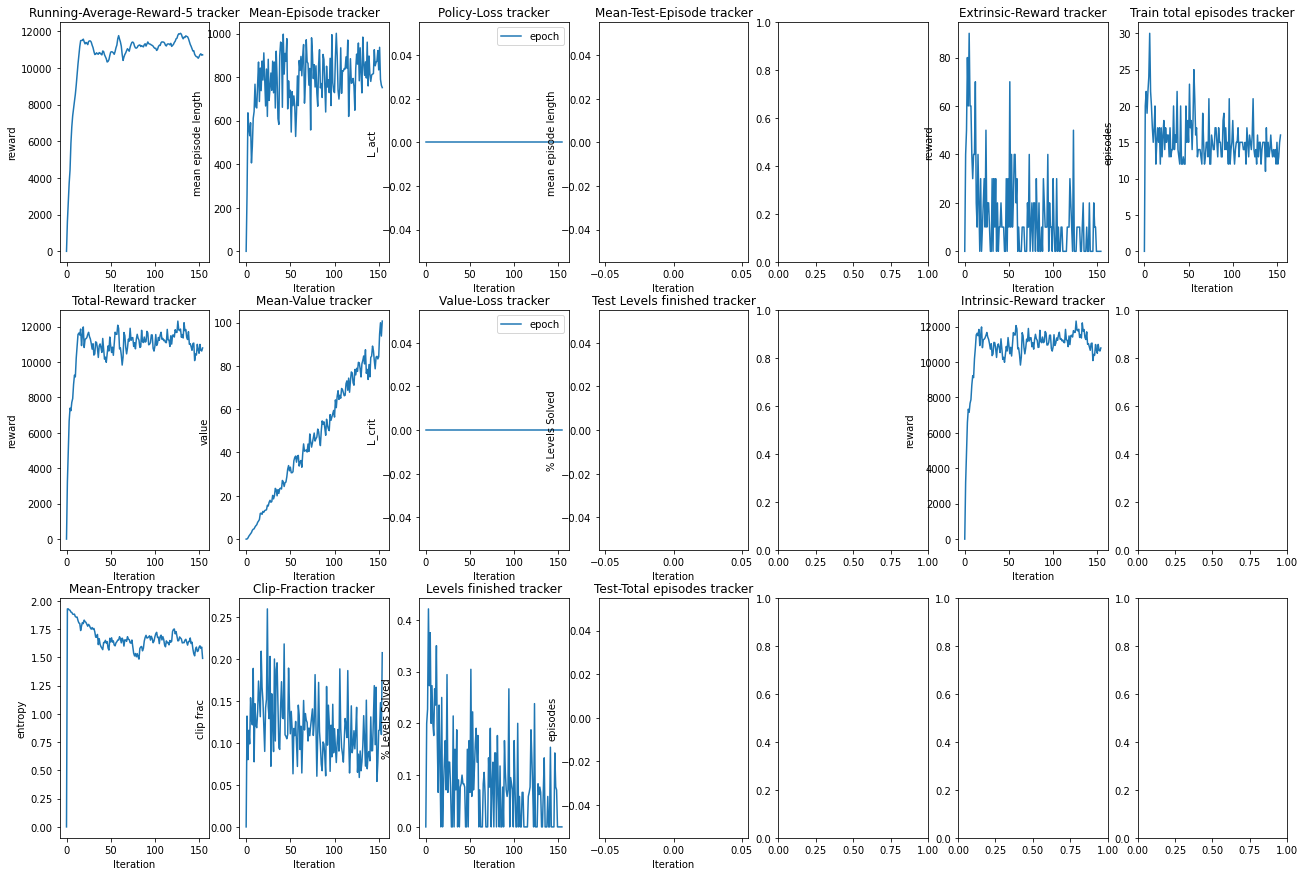

generation:  154
CoinRun ignores resets
Video saved!


In [ ]:
plot, graphics = Plot(), Graphics()
coinRun = CoinRun(TRAJECTORY_SIZE, NUM_TRAJECTORIES)
input_shape = coinRun.envs.observation_space.shape
input_shape = (input_shape[2], input_shape[1], input_shape[0])

actor_critic = ActorCritic(input_shape , coinRun.envs.action_space.n).to(device)
emb_network = Embedding(input_shape, coinRun.envs.action_space.n).to(device)

CONST_LEARNING_RATE, CONST_EPSILON = LEARNING_RATE, EPSILON

emb_optimizer =  optim.Adam(emb_network.parameters(), lr = EMB_LEARNING_RATE)

memory = Memory(emb_network)
generation = 0
if LOAD_SAVES:
  plot.load()
  actor_critic.load()
  generation = plot.iter

for update in range(generation, UPDATES):
  print("generation: ", generation)
  generation += 1

  progress = update / UPDATES
  LEARNING_RATE = CONST_LEARNING_RATE * (1-progress)
  EPSILON = CONST_EPSILON * (1-progress)
  actor_critic_optimizer = optim.Adam(actor_critic.parameters(), lr = LEARNING_RATE)
  if (generation - 1) % 50 == 0 and not LOAD_SAVES: # Since we save here, we don't need to evaluate the testenv twice
    if CREATE_SAVES and generation > 1:
      plot.save()
      actor_critic.save()

  states, actions, rewards, next_states, advs, refs, values, old_act_log_probs  = coinRun.step(actor_critic, memory)


  epoch_actor_loss, epoch_critic_loss, epoch_forward_loss, epoch_inverse_loss = 0, 0, 0, 0
  for epoch in range(EPOCHS):
    permutation = torch.randperm(states.shape[0])
    for i in range(0, states.shape[0], MINI_BATCH_SIZE):
      indices = permutation[i:i+MINI_BATCH_SIZE]
      batch_states, batch_acts, batch_rews, batch_next_states, batch_advs, batch_refs, batch_old_act_log_p, batch_values = states[indices], actions[indices], rewards[indices], next_states[indices], advs[indices], refs[indices], old_act_log_probs[indices], values[indices]

      actor_critic.zero_grad()
      distr, new_values = actor_critic(batch_states)
      actor_loss = actor_critic.entropy_clipLoss(batch_acts, batch_advs, batch_old_act_log_p, distr)
      critic_loss = 0.5 * actor_critic.valueLoss(batch_refs, batch_values, new_values.squeeze(-1))
      loss = actor_loss + critic_loss
      loss.backward()
      nn.utils.clip_grad_norm_(actor_critic.parameters(), MAX_GRADIENT_NORM)
      actor_critic_optimizer.step()

      if INTRINSIC_REWARD:
        emb_network.zero_grad()
        emb_loss = emb_network.getLoss(batch_states, batch_acts, batch_next_states)
        emb_loss.backward()
        emb_optimizer.step()



  plot.epoch_policy_loss(epoch_actor_loss / (epoch * states.shape[0] / MINI_BATCH_SIZE))
  plot.epoch_value_loss(epoch_critic_loss / (epoch * states.shape[0] / MINI_BATCH_SIZE))


  plot.show()

  LOAD_SAVES = False

In [ ]:
[1,2] * 2     
